# Gather All Insights from Exploratory Analysis

What can we glean from `process_explore_comments.ipynb`? 
* Number of comments across time
* Difference in sentiment across time 
* Difference in flavors between time and sentiment 
* Difference in flavors across sentiment

In [135]:
import pandas as pd

rate_comments = pd.read_csv("../data/csv/sesh_sentiment.csv")
rate_comments.head()

,date,text,score,title,sentiment
0,07/18/2024 09:10,i've noticed pouches with synthetic nicotine (...,3,american zyn nicotine pouches have to have som...,irrelevant
1,08/01/2023 02:15,this long long long reply will not be read bu...,1,am i putting pouches in wrong?,irrelevant
2,02/26/2024 20:52,they are my favorite mango. i wish sesh mango ...,2,anybody ever had these? picked these up at a g...,negative
3,04/22/2023 11:47,"haven’t tried the sesh, but the nic-s pouches ...",4,anybody have a take or impression on sesh+ or ...,irrelevant
4,04/21/2023 17:47,i was thinking about making a post about this ...,3,anybody have a take or impression on sesh+ or ...,positive


In [136]:
rate_comments.shape

(201, 5)

In [137]:
rate_comments.sentiment.value_counts(normalize=True)

irrelevant    0.517413
positive      0.208955
neutral       0.149254
negative      0.124378
Name: sentiment, dtype: float64

## Number of Comments Across Time

First, let's take a look at the number of comments that occur on Sesh products.

In [138]:
dummy_vars = pd.get_dummies(rate_comments.sentiment)
encoded = pd.merge(rate_comments.drop(columns=["sentiment"]), dummy_vars, left_index=True, right_index=True)

encoded["date"] = pd.to_datetime(encoded["date"])
sent_data = encoded.set_index("date")

sent_data.head()

,text,score,title,irrelevant,negative,neutral,positive
date,,,,,,,
2024-07-18 09:10:00,i've noticed pouches with synthetic nicotine (...,3,american zyn nicotine pouches have to have som...,1,0,0,0
2023-08-01 02:15:00,this long long long reply will not be read bu...,1,am i putting pouches in wrong?,1,0,0,0
2024-02-26 20:52:00,they are my favorite mango. i wish sesh mango ...,2,anybody ever had these? picked these up at a g...,0,1,0,0
2023-04-22 11:47:00,"haven’t tried the sesh, but the nic-s pouches ...",4,anybody have a take or impression on sesh+ or ...,1,0,0,0
2023-04-21 17:47:00,i was thinking about making a post about this ...,3,anybody have a take or impression on sesh+ or ...,0,0,0,1


In [139]:
import datetime as dt

sent_monthly = sent_data.resample("1M")[["positive", "negative", "neutral", "irrelevant"]].sum()
# cut off data before 2023 01 due to small sample size
select_date = sent_monthly[sent_monthly.index >= dt.datetime(2023, 1, 1)]

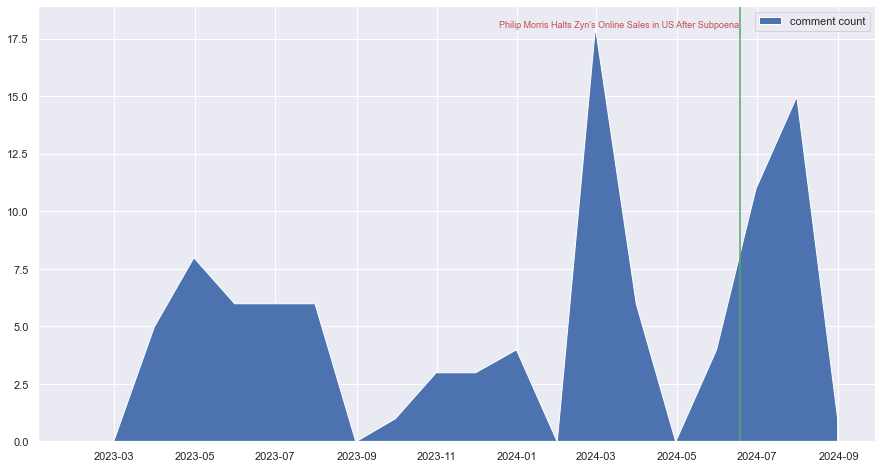

In [140]:
import matplotlib.pyplot as plt
import seaborn as sns

# calculate total number of comments
total_comments = select_date.drop(columns=["irrelevant"]).sum(axis=1)

plt.figure(figsize=(15,8))
# plt.ylim(0, 10)

sns.set_theme() 

plt.stackplot(total_comments.index, total_comments.values)
plt.legend(labels=['comment count'])

plt.text(x=dt.datetime(2023, 12, 18), y=18, s='Philip Morris Halts Zyn’s Online Sales in US After Subpoena', color='r', fontsize=9)
plt.axvline(x=dt.datetime(2024, 6, 18), color='g', label='axvline - full height')

# Differences in Sentiment Across Time

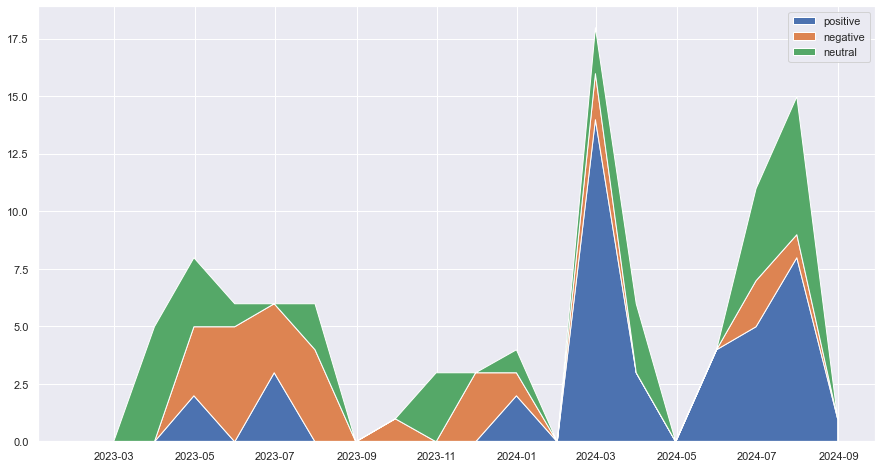

In [141]:
import seaborn as sns
import datetime as dt

positive = select_date["positive"]
negative = select_date["negative"]
neutral = select_date["neutral"]

plt.figure(figsize=(15,8))
# plt.ylim(0, 10)

sns.set_theme() 

plt.stackplot(positive.index, positive.values, negative.values, neutral.values)
plt.legend(labels=['positive', 'negative', "neutral"])

## Temporal Breakdown

It seems like 2023 data entailed a larger share of negative comments, while 2024 saw the opposite. Let's analyze the frequency of words in these 2 years.

<AxesSubplot:>

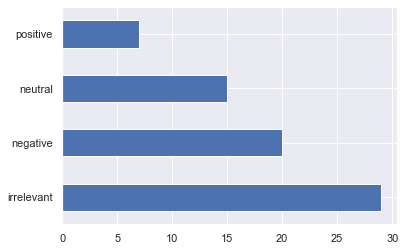

In [142]:
# aggregate all comments in 2023 and analyze

date_comments = rate_comments.set_index("date")
date_comments.index = pd.to_datetime(date_comments.index)

comments2023 = date_comments[date_comments.index < dt.datetime(2023, 12, 31)]

# how many neg/pos/neutral comments?
comments2023["sentiment"].value_counts().plot.barh()

In [143]:
comments2023["sentiment"].value_counts(normalize=True)

irrelevant    0.408451
negative      0.281690
neutral       0.211268
positive      0.098592
Name: sentiment, dtype: float64

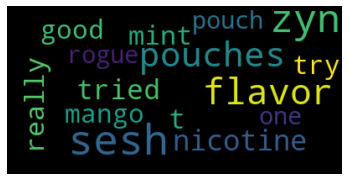

In [144]:
from wordcloud import WordCloud

comments2023 = comments2023["text"].tolist()

# make word cloud
wc = WordCloud(max_font_size=50, max_words=15).generate(" ".join(comments2023))
plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

<AxesSubplot:>

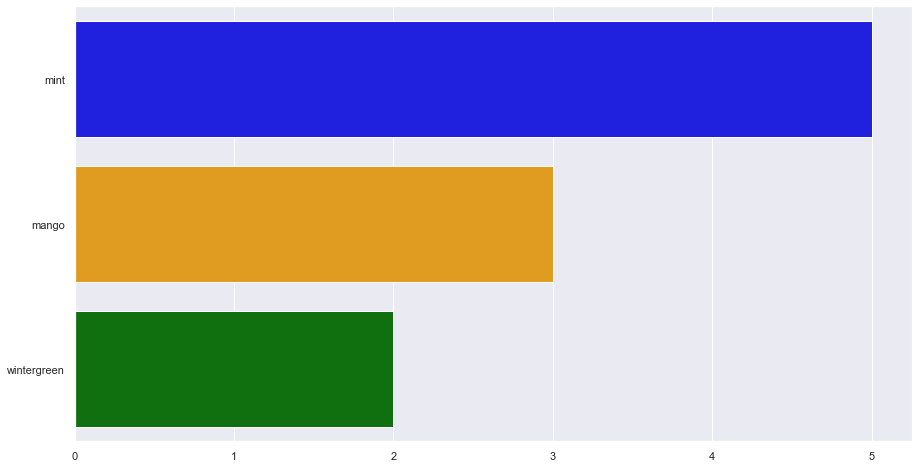

In [145]:
# flavor analysis in 2023 across negative sentiments 

list_comments = date_comments[(date_comments["sentiment"] == "negative") & (date_comments.index < dt.datetime(2023, 12, 31))]["text"].tolist()

flavors = ["mint", "mango", "wintergreen"]
colors = ["blue", "orange", "green"]

# analyze frequency on flavors in negative 2023 comments
neg_rates = []
for flavor in flavors:
    count = len([1 for comment in list_comments if flavor in comment])
    neg_rates.append(count)

plt.figure(figsize=(15,8))
sns.barplot(x=neg_rates, y=flavors, palette=colors)

In [146]:
neg_rates

[5, 3, 2]

<AxesSubplot:>

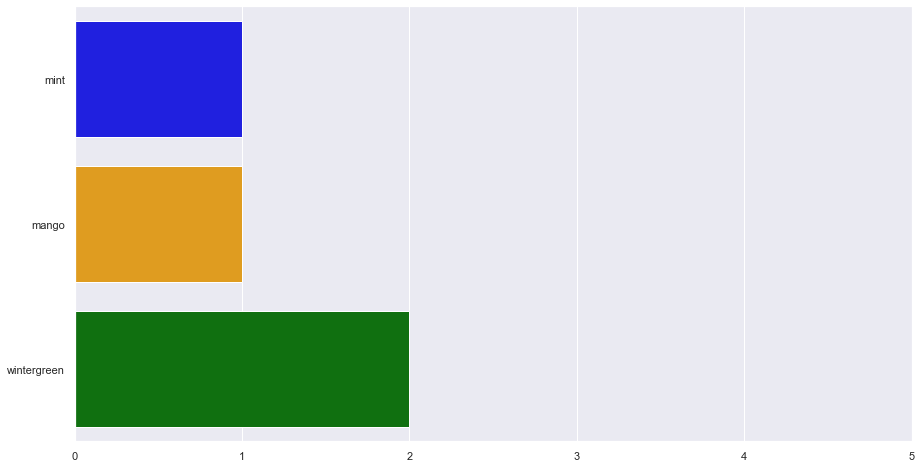

In [147]:
# flavor analysis in 2023 across positive sentiments 

list_comments = date_comments[(date_comments["sentiment"] == "positive") & (date_comments.index < dt.datetime(2023, 12, 31))]["text"].tolist()

flavors = ["mint", "mango", "wintergreen"]
colors = ["blue", "orange", "green"]

# analyze frequency on flavors in negative 2023 comments
pos_rates = []
for flavor in flavors:
    count = len([1 for comment in list_comments if flavor in comment])
    pos_rates.append(count)

plt.figure(figsize=(15,8))
plt.xlim(right=5)
sns.barplot(x=pos_rates, y=flavors, palette=colors)

In [148]:
pos_rates

[1, 1, 2]

<AxesSubplot:>

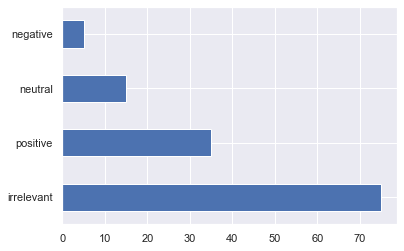

In [149]:
# aggregate all comments in 2024 and analyze

comments2024 = date_comments[date_comments.index >= dt.datetime(2024, 1, 1)]

# how many neg/pos/neutral comments?
comments2024["sentiment"].value_counts().plot.barh()

In [150]:
comments2024["sentiment"].value_counts(normalize=True)

irrelevant    0.576923
positive      0.269231
neutral       0.115385
negative      0.038462
Name: sentiment, dtype: float64

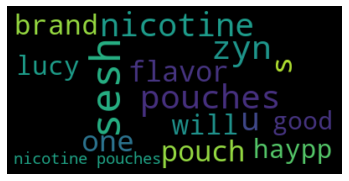

In [151]:
from wordcloud import WordCloud

comments2024 = comments2024["text"].tolist()

# make word cloud
wc = WordCloud(max_font_size=50, max_words=15).generate(" ".join(comments2024))
plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

<AxesSubplot:>

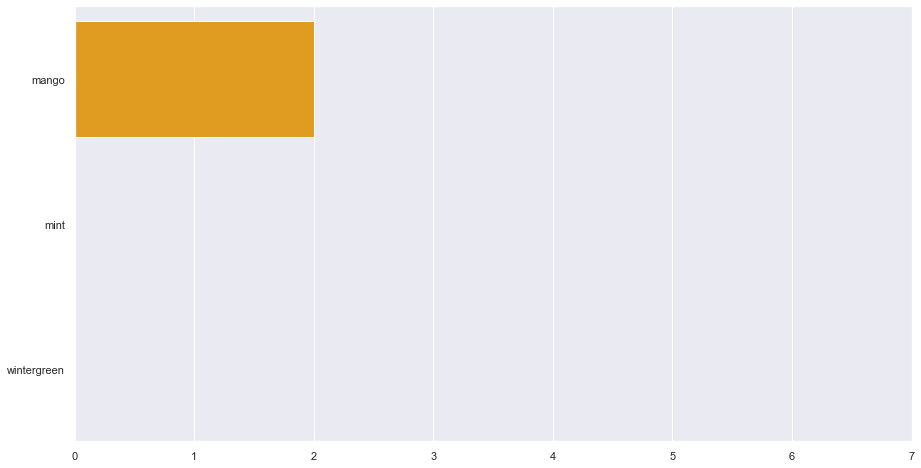

In [152]:
# flavor analysis in 2024 across negative sentiments 

list_comments = date_comments[(date_comments["sentiment"] == "negative") & (date_comments.index >= dt.datetime(2024, 1, 1))]["text"].tolist()

flavors = ["mango", "mint", "wintergreen"]
colors = ["orange", "blue", "green"]

# analyze frequency on flavors in negative 2023 comments
neg_rates = []
for flavor in flavors:
    count = len([1 for comment in list_comments if flavor in comment])
    neg_rates.append(count)

plt.figure(figsize=(15,8))
plt.xlim(right=7)
sns.barplot(x=neg_rates, y=flavors, palette=colors)

<AxesSubplot:>

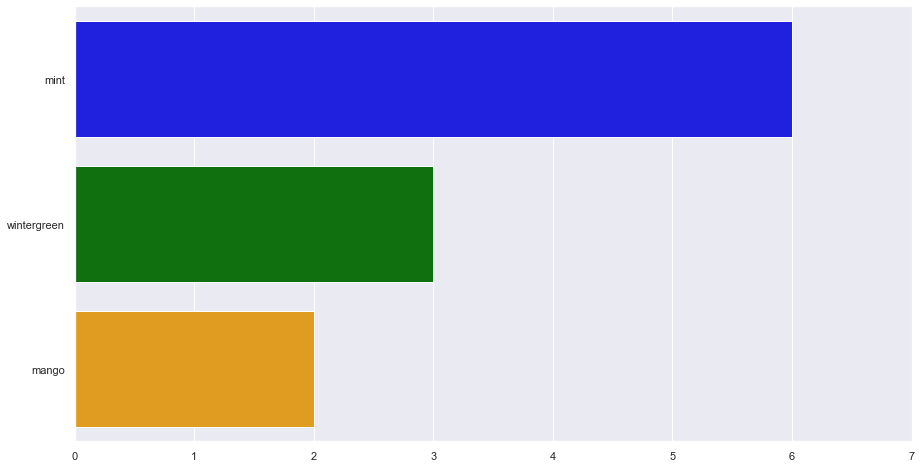

In [153]:
# flavor analysis in 2024 across positive sentiments 

list_comments = date_comments[(date_comments["sentiment"] == "positive") & (date_comments.index >= dt.datetime(2024, 1, 1))]["text"].tolist()

flavors = ["mint", "wintergreen", "mango"]
colors = ["blue", "green", "orange"]

# analyze frequency on flavors in negative 2023 comments
pos_rates = []
for flavor in flavors:
    count = len([1 for comment in list_comments if flavor in comment])
    pos_rates.append(count)

plt.figure(figsize=(15,8))
plt.xlim(right=7)
sns.barplot(x=pos_rates, y=flavors, palette=colors)

In [154]:
pos_rates

[6, 3, 2]

# Differences in Flavors Across Sentiment

<AxesSubplot:title={'center':'How often are different flavors mentioned?'}>

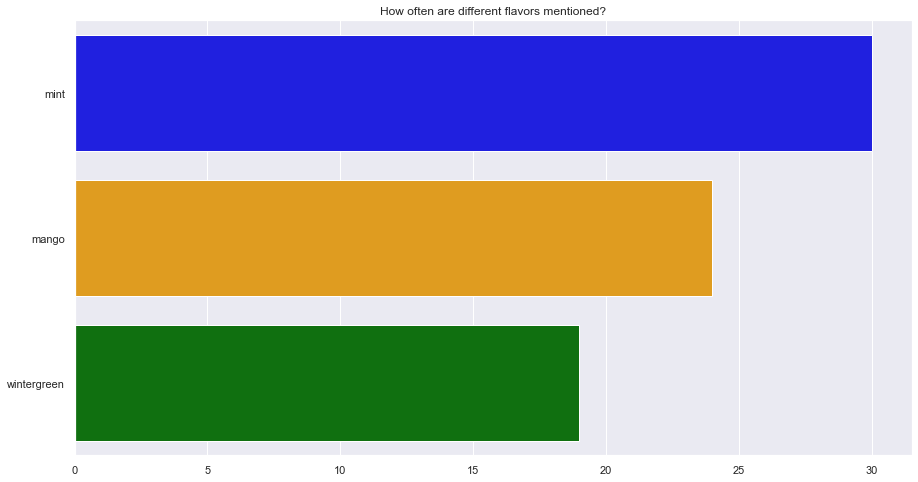

In [155]:
# across all comments
flavors = ["mint", "mango", "wintergreen"]
colors = ["blue", "orange", "green"]

# analyze frequency on flavors in positive comments
comments = rate_comments["text"].tolist()

rates = []
for flavor in flavors:
    count = len([1 for comment in comments if flavor in comment])
    rates.append(count)

plt.figure(figsize=(15,8))
plt.title("How often are different flavors mentioned?")
sns.barplot(x=rates, y=flavors, palette=colors)

In [156]:
rates

[30, 24, 19]

In [157]:
# breakdown across all sentiments

flavors = ["mint", "wintergreen", "mango"]
colors = ["blue", "green", "orange"]

data = {
    "flavor": [],
    "sentiment": [],
    "frequency": [],
}

# analyze frequency on flavors in positive comments
pos_comments = rate_comments[rate_comments["sentiment"] == "positive"]["text"].tolist()
pos_rates = []
for flavor in flavors:
    count = len([1 for comment in pos_comments if flavor in comment])
    data["flavor"] += [flavor]
    data["sentiment"] += ["positive"]
    data["frequency"] += [count]

# analyze frequency in neutral comments
neut_comments = rate_comments[rate_comments["sentiment"] == "neutral"]["text"].tolist()
neut_rates = []
for flavor in flavors:
    count = len([1 for comment in neut_comments if flavor in comment])
    neut_rates.append(count)
    data["flavor"] += [flavor]
    data["sentiment"] += ["neutral"]
    data["frequency"] += [count]

# analyze frequency on flavors in negative comments
neg_comments = rate_comments[rate_comments["sentiment"] == "negative"]["text"].tolist()
neg_rates = []
for flavor in flavors:
    count = len([1 for comment in neg_comments if flavor in comment])
    neg_rates.append(count)
    data["flavor"] += [flavor]
    data["sentiment"] += ["negative"]
    data["frequency"] += [count]

flavor_df = pd.DataFrame(data=data)
flavor_df

,flavor,sentiment,frequency
0,mint,positive,7
1,wintergreen,positive,5
2,mango,positive,3
3,mint,neutral,8
4,wintergreen,neutral,5
5,mango,neutral,6
6,mint,negative,5
7,wintergreen,negative,2
8,mango,negative,5


<AxesSubplot:xlabel='sentiment', ylabel='frequency'>

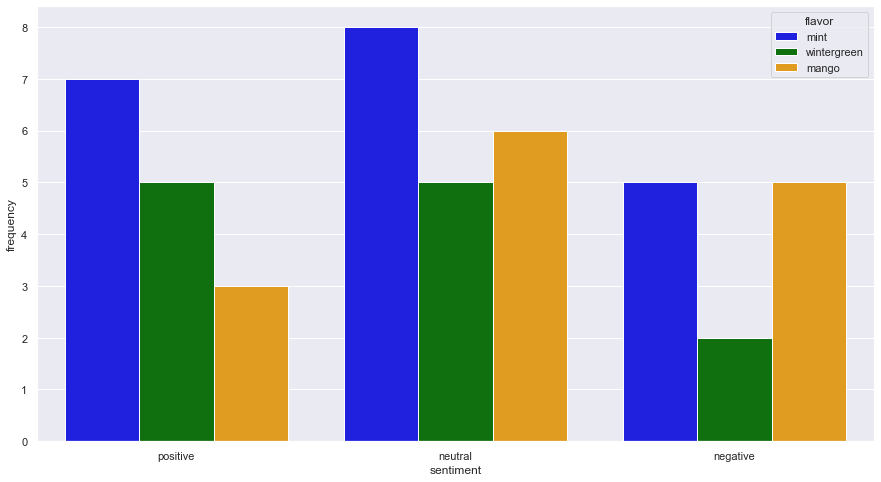

In [158]:
plt.figure(figsize=(15,8))
sns.barplot(data=flavor_df, x='sentiment', y='frequency', hue='flavor', palette=colors)

# Conclusion

**Number of comments across time**
* Fairly sparse and intermittent posting on sesh nicotine pouches
* 201 comments collected in total
    * 104 were irrelevant to the analysis (~52%)
    * 42 were marked as positive (~21%)
    * 30 were marked as neutral (~15%)
    * 25 were marked as negative (~12%)

**Difference in sentiment across time**
* While both years had mostly irrelevant comments (~41% for 2023; ~58% for 2024)
* 2023 had a greater proportion of negative sentiment comments (20) (~28%)
* While 2024 saw greater proportion of positive sentiment comments (35) (~27%)

**Difference in flavors between time and sentiment**
* Overall mint was the most commented on flavor (30), then mango (24), and finally wintergreen (19)
* In 2023 
    * Mint was the most frequent flavor key-word in negative sentiment comments (5)
    * Wintergreen was the most frequent flavor key-word in positive sentiment comments (2)
* In 2024
    * Mango was the most frequent (and only) flavor key-word in negative sentiment comments (2)
    * Mint was the most frequent flavor key-word in positive sentiment comments (6)

**Difference in flavors across sentiment**
* Mint is the most frequency flavor key-word in positive sentiment comments (7); Mango being the least (3)
* Mint is also most frequency flavor key-word in neutral sentiment comments (8); Wintergreen being the least (5)
* Mint and Mango are the most frequency flavor key-words in negative sentiment comments (5); Wintergreen being the least (2)